Accuracy: 0.0
Tree saved as id3_decision_tree.png


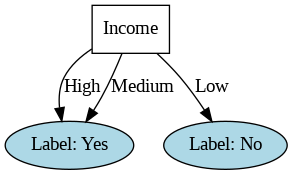

In [2]:
import math
from collections import Counter
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import graphviz

# -------------------------------
# Step 1: Dataset
# -------------------------------
data = [
    ['Young', 'High', 'Yes', 'Good', 'Yes'],
    ['Young', 'Medium', 'No', 'Poor', 'No'],
    ['Middle', 'High', 'Yes', 'Good', 'Yes'],
    ['Senior', 'Low', 'No', 'Poor', 'No'],
    ['Senior', 'Medium', 'Yes', 'Good', 'Yes'],
    ['Young', 'Low', 'Yes', 'Poor', 'No'],
    ['Middle', 'Medium', 'No', 'Good', 'Yes'],
    ['Senior', 'High', 'No', 'Good', 'Yes'],
    ['Young', 'Medium', 'Yes', 'Good', 'Yes'],
    ['Middle', 'Low', 'No', 'Poor', 'No']]

# Attribute names
attributes = ['Age Group', 'Income', 'Wants Luxury', 'Credit Score', 'Buys Car']

df = pd.DataFrame(data, columns=attributes)

# -------------------------------
# Step 2: Entropy & Info Gain
# -------------------------------
def entropy(data):
    labels = data.iloc[:, -1]
    counts = Counter(labels)
    total = len(labels)
    return -sum((count / total) * math.log2(count / total) for count in counts.values())

def info_gain(data, attribute):
    total_entropy = entropy(data)
    values = data[attribute].unique()
    subset_entropy = 0
    for v in values:
        subset = data[data[attribute] == v]
        subset_entropy += (len(subset) / len(data)) * entropy(subset)
    return total_entropy - subset_entropy

# -------------------------------
# Step 3: ID3 Tree Building
# -------------------------------
def id3(data, attributes, min_gain=0.0):
    labels = data.iloc[:, -1]

    if len(labels.unique()) == 1:
        return labels.iloc[0]
    if not attributes:
        return labels.mode()[0]

    gains = {attr: info_gain(data, attr) for attr in attributes}
    best_attr = max(gains, key=gains.get)

    if gains[best_attr] < min_gain:
        return labels.mode()[0]

    tree = {best_attr: {}}
    for val in data[best_attr].unique():
        subset = data[data[best_attr] == val]
        subtree = id3(subset.drop(columns=[best_attr]), [a for a in attributes if a != best_attr])
        tree[best_attr][val] = subtree

    return tree

# -------------------------------
# Step 4: Prediction
# -------------------------------
def predict(tree, instance):
    if not isinstance(tree, dict):
        return tree
    attr = next(iter(tree))
    val = instance.get(attr)
    if val not in tree[attr]:
        return "Unknown"  # Fallback for unseen attribute value
    return predict(tree[attr][val], instance)

# -------------------------------
# Step 5: Train, Test, Accuracy
# -------------------------------
attributes = list(df.columns[:-1])
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
tree = id3(train_df, attributes)

y_true = test_df['Credit Score']
y_pred = test_df.apply(lambda row: predict(tree, row), axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))

# -------------------------------
# Step 6: Export Tree to JSON
# -------------------------------
with open("id3_tree.json", "w") as f:
    json.dump(tree, f, indent=2)

# -------------------------------
# Step 7: Visualize Tree using Graphviz
# -------------------------------
def visualize_tree(tree, dot=None, parent=None, edge_label=""):
    if dot is None:
        dot = graphviz.Digraph()
        dot.attr('node', shape='box')

    if not isinstance(tree, dict):
        node_name = f'Leaf_{id(tree)}'
        dot.node(node_name, label=f'Label: {tree}', shape='ellipse', style='filled', fillcolor='lightblue')
        if parent:
            dot.edge(parent, node_name, label=edge_label)
        return dot

    root_attr = next(iter(tree))
    root_node = f'Attr_{root_attr}_{id(tree)}'
    dot.node(root_node, label=root_attr)

    if parent:
        dot.edge(parent, root_node, label=edge_label)

    for val, subtree in tree[root_attr].items():
        visualize_tree(subtree, dot, parent=root_node, edge_label=str(val))

    return dot

# Generate and save the decision tree diagram
dot = visualize_tree(tree)
dot.render("id3_decision_tree", format="png", cleanup=True)
print("Tree saved as id3_decision_tree.png")

# Display the PNG in notebook or output
from IPython.display import Image, display
display(Image(filename="id3_decision_tree.png"))
